# 3. Model - VAR 퉷

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

import seaborn as sn

import math

## 3.0. Importing Data

In [14]:
tr = []; sn24 = []; sn360 = []; sn8760 = []; re = []
full_data = [tr, sn24, sn360, sn8760, re]
name = ["trend", "seasonal_24", "seasonal_360", "seasonal_8760", "residual"]

for i in range(len(name)):
    comp = name[i]
    for j in range(7):
        x_train = pd.read_csv(f"./pca_data_newofnew/{comp}_data/x_train_{comp}_split{j}.csv")
        y_train = pd.read_csv(f"./pca_data_newofnew/{comp}_data/y_train_{comp}_split{j}.csv")
        x_valid = pd.read_csv(f"./pca_data_newofnew/{comp}_data/x_valid_{comp}_split{j}.csv")
        y_valid = pd.read_csv(f"./pca_data_newofnew/{comp}_data/y_valid_{comp}_split{j}.csv")
        split_data = [x_train, y_train, x_valid, y_valid]
        full_data[i].append(split_data)

In [36]:
# checking...
pd.concat([full_data[0][0][0], full_data[0][1][0], full_data[0][2][0]], axis = 1)

# working!!

,pca1,pca2,pca1,pca2,pca1,pca2,pca3
0,6.048782,0.235696,5.472843,4.902037,7.171119,2.398997,-0.471545
1,6.046353,0.235348,5.472381,4.892513,7.167298,2.395817,-0.470760
2,6.043923,0.235001,5.471917,4.882991,7.163477,2.392637,-0.469974
3,6.041493,0.234654,5.471452,4.873471,7.159655,2.389457,-0.469188
4,6.039063,0.234308,5.470986,4.863953,7.155832,2.386277,-0.468402
...,...,...,...,...,...,...,...
5003,-5.907693,0.120556,-1.996746,-2.705171,-3.399519,3.425415,0.856099
5004,-5.910006,0.120649,-1.994790,-2.710769,-3.399788,3.428603,0.857802
5005,-5.912318,0.120742,-1.992831,-2.716372,-3.400056,3.431791,0.859506
5006,-5.914631,0.120835,-1.990871,-2.721981,-3.400324,3.434980,0.861210


## 3.1. Basic EDA

### 3.1.1. Causation Test

using Granger's Causality test...

*null hypo*: the coeff. of past values in the regression equation is zero => past terms do not cause the other series data

It shows the matrix of all possible combinations of the time series..

* rows: response variable
* columns: predictors

In [37]:
from statsmodels.tsa.stattools import grangercausalitytests

In [38]:
maxlag = 1

In [39]:
def grangers_causation_mtx(data, variables, test = "ssr_chi2test"):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index = variables)
    for col in df.columns:
        for row in df.index:
            test_result = grangercausalitytests(data[[col, row]], maxlag = maxlag, verbose = False)
            p_val = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            min_p_val = np.min(p_val)
            df.loc[col, row] = min_p_val
    df.columns = [var + "_x" for var in variables]
    df.index = [var + "_y" for var in variables]
    return df

In [40]:
import warnings
warnings.filterwarnings(action='ignore') 

for comp in full_data:
    for split in comp:
        data = pd.concat([split[0], split[1]], axis = 1)
        print(grangers_causation_mtx(data, variables = data.columns))
    print("======")
    
warnings.filterwarnings(action='default')

        pca1_x  pca2_x  0_x
pca1_y  0.9998     0.0  0.0
pca2_y  0.0000     1.0  0.0
0_y     0.0000     0.0  1.0
        pca1_x  pca2_x  0_x
pca1_y     1.0     0.0  0.0
pca2_y     0.0     1.0  0.0
0_y        0.0     0.0  1.0
        pca1_x  pca2_x  pca3_x  0_x
pca1_y     1.0  0.0000    0.00  0.0
pca2_y     0.0  1.0000    0.01  0.0
pca3_y     0.0  0.0000    1.00  0.0
0_y        0.0  0.1066    0.00  1.0
        pca1_x  pca2_x  pca3_x  0_x
pca1_y     1.0     0.0     0.0  0.0
pca2_y     0.0     1.0     0.0  0.0
pca3_y     0.0     0.0     1.0  0.0
0_y        0.0     0.0     0.0  1.0
        pca1_x  pca2_x  0_x
pca1_y     1.0     0.0  0.0
pca2_y     0.0     1.0  0.0
0_y        0.0     0.0  1.0
        pca1_x  pca2_x  pca3_x  0_x
pca1_y     1.0     0.0     0.0  0.0
pca2_y     0.0     1.0     0.0  0.0
pca3_y     0.0     0.0     1.0  0.0
0_y        0.0     0.0     0.0  1.0
        pca1_x  pca2_x  0_x
pca1_y     1.0     0.0  0.0
pca2_y     0.0     1.0  0.0
0_y        0.0     0.0  1.0
        pca1

### 3.1.2. Conintegration Test

* *order of integration*: number of differencing required to make a non-stationary time series stationary
* *conintegration*: if there exists a linear combination of them that has an order of integration less than that of the individual series

In [41]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [42]:
def cointegration_test(df, alpha = 0.05):
    out = coint_johansen(df, -1, 5)
    d = {"0.90":0, "0.95" :1, "0.99": 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length = 6):
        return str(val).ljust(length)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [43]:
print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)

    
for comp in full_data:
    for split in comp:
        data = pd.concat([split[0], split[1]], axis = 1)
        cointegration_test(data)
    print("======")


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
pca1   ::  1948.36   > 24.2761   =>   True
pca2   ::  661.96    > 12.3212   =>   True
0      ::  81.2      > 4.1296    =>   True
pca1   ::  54.42     > 24.2761   =>   True
pca2   ::  21.17     > 12.3212   =>   True
0      ::  0.26      > 4.1296    =>   False
pca1   ::  212.95    > 40.1749   =>   True
pca2   ::  108.86    > 24.2761   =>   True
pca3   ::  45.0      > 12.3212   =>   True
0      ::  0.03      > 4.1296    =>   False
pca1   ::  155.13    > 40.1749   =>   True
pca2   ::  12.3      > 24.2761   =>   False
pca3   ::  2.81      > 12.3212   =>   False
0      ::  0.17      > 4.1296    =>   False
pca1   ::  143.07    > 24.2761   =>   True
pca2   ::  46.4      > 12.3212   =>   True
0      ::  8.12      > 4.1296    =>   True
pca1   ::  270.63    > 40.1749   =>   True
pca2   ::  100.95    > 24.2761   =>   True
pca3   ::  9.41      > 12.3212   =>   False
0      ::  0.0       > 4.1296    =>   False
p

### 3.1.3. Stationary Test - ADF Test

In [44]:
# defined on EDA.ipynb
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    #timeseries.iloc[:, 0] = pd.to_numeric(timeseries.iloc[:, 0])
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    return dftest[1]

In [ ]:
name_comp = ["trend", "seasonal_24", "seasonal_360", "seasonal_8760", "residual"]

for i, comp in enumerate(full_data):
    print("=======", name_comp[i])
    for j, split in enumerate(comp):
        print("----------- split", j)
        for i in range(2):
            for name, column in split[i].items():
                adf_test(column) 
                print('\n')

======= trend
----------- split 0
Results of Dickey-Fuller Test:
Test Statistic                   -1.078834
p-value                           0.723438
#Lags Used                       32.000000
Number of Observations Used    4975.000000
Critical Value (1%)              -3.431665
Critical Value (5%)              -2.862121
Critical Value (10%)             -2.567079
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                    0.025720
p-value                           0.960608
#Lags Used                       32.000000
Number of Observations Used    4975.000000
Critical Value (1%)              -3.431665
Critical Value (5%)              -2.862121
Critical Value (10%)             -2.567079
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                    0.995866
p-value                           0.994222
#Lags Used                       29.000000
Number of Observations Used    4978.000000
Critical Value (1%)              -3.431664
Critical Value (5%)   

We have checked that *most of trend component* is not satisfying the stationary condition...

Since the data of trend component is almost constant(**not actually**), it is considered to take *IHS transformation* rather than taking differentiation.

**WHY might NOT box-cox**: It cannot deal with data containing negative values.. *but able to apply if the data are transformed to be all positive*. 

In [195]:
def boxcox(df):
    fitted_df, fitted_lambda = stats.boxcox(df)
    fig, ax = plt.subplots(1, 2)
    
    ax[0].plot(
        np.arange(5008),
        df,
        label = "original",
        color = "blue"
    )
    ax[1].plot(
        np.arange(5008),
        fitted_df, 
        label = "IHS", 
        color = "green"
    )
    
    fig.show()
    
    return fitted_df

Results of Dickey-Fuller Test:
Test Statistic                   -4.896741
p-value                           0.000035
#Lags Used                       18.000000
Number of Observations Used    4989.000000
Critical Value (1%)              -3.431661
Critical Value (5%)              -2.862120
Critical Value (10%)             -2.567078
dtype: float64


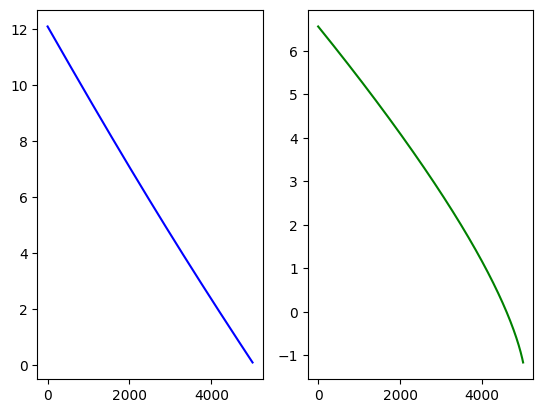

In [196]:
sample_data = full_data[0][0][0]

for name, column in sample_data.items():
    x = column.to_numpy()
    c = -min(x) + 0.1
    trans_x = x + c
    trans_x = boxcox(trans_x) - c
    adf_test(trans_x)

In [197]:
from scipy.optimize import minimize

In [198]:
IHS = lambda x, theta: (1/theta)*np.arcsinh(theta * x)
inv_IHS = lambda x, theta: (1/theta)*np.sinh(theta * x)

stationary_p_val = lambda theta, x: adfuller(IHS(x, theta), autolag="AIC")[1]

In [ ]:
sample_data = full_data[0][0][0]

for name, column in sample_data.items():
    x = column.to_numpy()
    theta = np.array([0.1])
    resa = minimize(
        fun = stationary_p_val,
        args = (x),
        x0 = theta,
        method = 'Nelder-Mead'
    )
    print(resa)
    print("-------")

In [ ]:
for name, column in sample_data.items():
    x = column.to_numpy(); theta = 1.025e-01
    fitted_x = IHS(x, theta)
    
    fig, ax = plt.subplots(1, 2)

    ax[0].plot(
        np.arange(5008),
        x,
        label = "original",
        color = "blue"
    )
    ax[1].plot(
        np.arange(5008),
        fitted_x, 
        label = "IHS", 
        color = "green"
    )
    
    fig.show()

In [ ]:
stationary_p_val(x)

In [ ]:
adf_test(fitted_x)

## 3.2. VAR Modeling

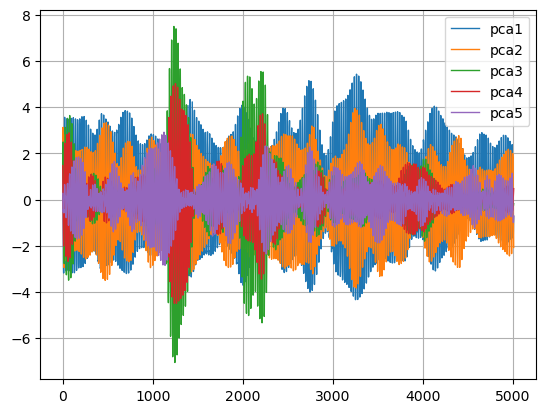

In [15]:
full_data[1][2][0].plot(
    kind = "line",
    y = ["pca1", "pca2", "pca3", "pca4", "pca5"],
    lw = 1,
    grid = True
)


In [268]:
full_data[1][1][0]

,pca1,pca2,pca3,pca4
0,3.350298,1.596048,-1.004746,-0.172629
1,3.512930,1.275282,-0.788717,-0.639776
2,3.328078,1.302831,-0.850368,-0.510029
3,3.357569,1.145522,-0.735353,-0.727012
4,3.218598,1.151311,-0.472318,-1.003720
...,...,...,...,...
5003,1.113786,-1.597136,-0.132610,-0.880227
5004,1.397364,-1.421984,-0.122278,-0.858214
5005,1.679274,-1.205025,-0.102336,-0.823172
5006,1.820763,-0.579473,-0.151146,-0.526762


important to select the *suitable order*

In [16]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [221]:
# full_data <- 어케 생긴 거임ㅋㅋ
# full_data[0][0][0] # x_train
# full_data[0][0][1] # y_train
# full_data[0][0][2] # x_valid
# full_data[0][0][3] # y_valid
# full_data[0][0] # [x_train, y_train, x_valid, y_valid] ... one block

In [222]:
# full_data[0] # 7 blocks

In [12]:
# full_data # [trend, seasonal, residual]

<Axes: >

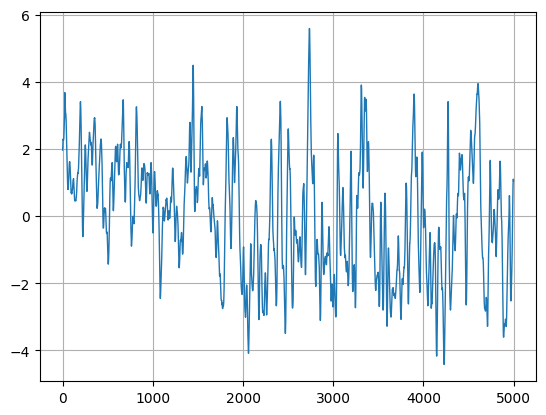

In [50]:
full_data[3][0][0].iloc[:5000,1].plot(
    kind = "line",
    y = ["pca1"],
    lw = 1,
    grid = True
)

<Axes: >

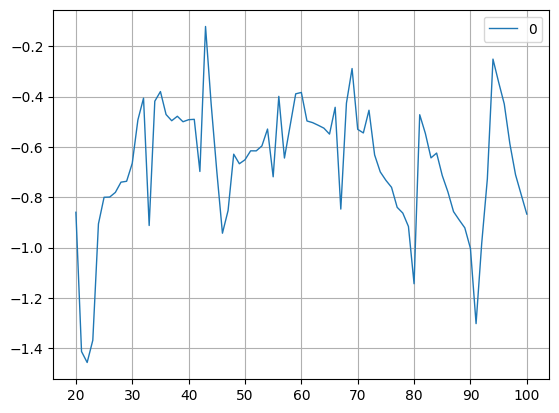

In [51]:
full_data[3][0][1].loc[20:100].plot(
    kind = "line",
    y = ["0"],
    lw = 1,
    grid = True
)

In [52]:
min_p = []
results_aic = []
for data in full_data:
    # trend -> seasonal -> residual
    aic = [0] * 39
    for block_data in data:
        # blocking cv
        X_train = block_data[0]
        y_train = block_data[1]
        X_valid = block_data[2]
        y_valid = block_data[3]
        
        df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
        df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
        
        forecasting_model = VAR(df_train)
        criteria = forecasting_model.select_order(maxlags = 40)
        print(criteria.summary())

        # for p in range(1, 40):
        #     forecasting_model = VAR(df_train)
        #     results = forecasting_model.fit(p)
        #     aic[p-1] += results.aic
    # min_p.append(np.argmin(aic) + 1)
    # results_aic.append(aic)
    
# X_train, y_train, X_valid, y_train 
# forecasting_model = VAR(full)
# results_aic = []
# for p in range(1,10):
#   results = forecasting_model.fit(p)
#   results_aic.append(results.aic)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.51      -13.50   1.361e-06      -13.51
1       -75.26      -75.25   2.058e-33      -75.26
2       -124.1      -124.1   1.226e-54      -124.1
3       -149.9      -149.9   7.804e-66      -149.9
4       -150.9      -150.8   2.915e-66      -150.9
5       -151.3      -151.2   2.038e-66      -151.2
6       -151.6      -151.5   1.463e-66      -151.6
7       -151.9      -151.8   1.065e-66      -151.9
8       -152.2      -152.1   8.165e-67      -152.1
9       -152.4      -152.3   6.567e-67      -152.4
10      -152.6      -152.5   5.323e-67      -152.6
11      -152.8      -152.6   4.474e-67      -152.7
12      -153.0      -152.8   3.716e-67      -152.9
13      -153.1      -152.9   3.298e-67      -153.0
14      -153.1      -153.0   3.137e-67      -153.1
15      -153.2      -153.0   3.039e-67      -153.1
16      -153.2      -153.0   2.

In [9]:
print(results_aic)
print(min_p)

[[-340.94090610692547, -586.2300795201145, -757.6992563602834, -769.7573542671341, -775.0540013840418, -778.0725047839562, -780.1572358461232, -781.7353664983493, -783.0145041833932, -784.6157092056587, -784.7149916981931, -786.123726765688, -785.384782418443, -786.2869622122796, -787.3927639072598, -786.8194626377744, -785.761857586969, -786.4290550037045, -787.3147954689091, -786.0905273689054, -784.9588929052026, -784.1253284845723, -787.3403444762766, -786.8685809327269, -786.2562140544904, -785.4032877230959, -787.5054574562035, -786.2104517393839, -785.829922028919, -788.5896632714043, -786.0288825715048, -786.7183781101744, -785.734842274536, -787.1057735935987, -784.789921591144, -787.265395383202, -785.9738492322783, -785.7834195599804, -787.730290367212], [-77.63538544605896, -96.85109228400634, -101.5154445887842, -103.71259998268798, -104.70528904671141, -105.42943889545305, -106.15338792042013, -106.92554923363285, -107.9207898870011, -109.01525787562669, -110.149048555839

In [17]:
from sklearn.metrics import mean_squared_error 
def SMAPE(y_test, y_pred):
    y_test = y_test.to_numpy(); y_pred = y_pred.to_numpy()
    return np.mean((np.abs(y_test-y_pred))/(np.abs(y_test)+np.abs(y_pred)))*100
def RMSE(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [18]:
def draw_plot(y_test, y_pred):
    X = np.linspace(0, len(y_test), len(y_test))
    plt.plot(X, y_test, label='obs')
    plt.plot(X, y_pred, label='pred')
    plt.legend()
    plt.show()

In [19]:
residual_data = full_data[3]
lag = 15
step = 6
size = 30

for block_data in residual_data:
    X_train = block_data[0]
    y_train = block_data[1]
    X_valid = block_data[2]
    y_valid = block_data[3]
    SMAPE_sum = 0
    RMSE_sum = 0
        
    df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
    df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
    
    forecasting_model = VAR(df_train)
    results = forecasting_model.fit(lag)
    
    df_valid = pd.concat([df_train.loc[-lag: , :], df_valid])
    
    for i in range(0, len(df_valid)-lag):
        lagged_values = df_valid.values[i: i+lag]
        forecast = pd.DataFrame(results.forecast(y = lagged_values, steps = step), columns=df_train.columns)
        # print(forecast)
        SMAPE_sum += SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])
        RMSE_sum += RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])
        #print(f"SMAPE {SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")
        #print(f"RMSE {RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")  
    print(f"SMAPE avg {SMAPE_sum / (len(df_valid) - lag)}, RMSE avg {RMSE_sum / (len(df_valid) - lag)}")
        #draw_plot(df_valid.iloc[i+1: i+step+1, [0]], forecast.iloc[:step,[0]])

SMAPE avg 32.33362860193947, RMSE avg 0.41603721113273967
SMAPE avg 35.06266497996701, RMSE avg 0.41869972986673387
SMAPE avg 21.32903996107692, RMSE avg 0.20445476761171352
SMAPE avg 19.92896051202073, RMSE avg 0.16858407036001372
SMAPE avg 38.18282018866233, RMSE avg 0.655258343432078
SMAPE avg 16.010612850769387, RMSE avg 0.14448420340933926
SMAPE avg 20.245432550971714, RMSE avg 0.1886603658887336


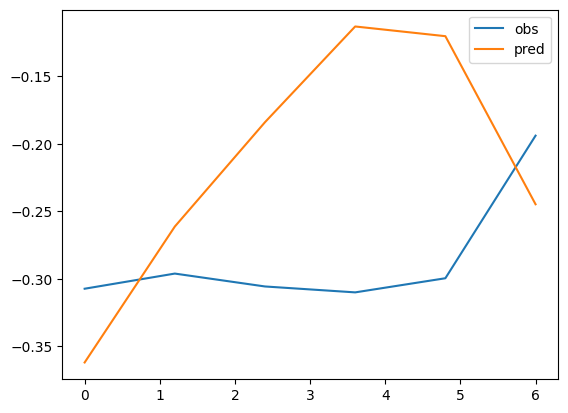

In [14]:
draw_plot(df_valid.iloc[i+1: i+step+1, [0]], forecast.iloc[:step,[0]])

SMAPE avg 33.73359106693402, RMSE avg 0.4151601591817285


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


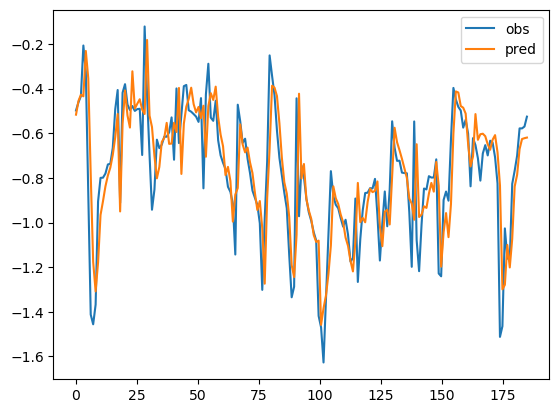

SMAPE avg 38.333062828250526, RMSE avg 0.4259039221131866


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


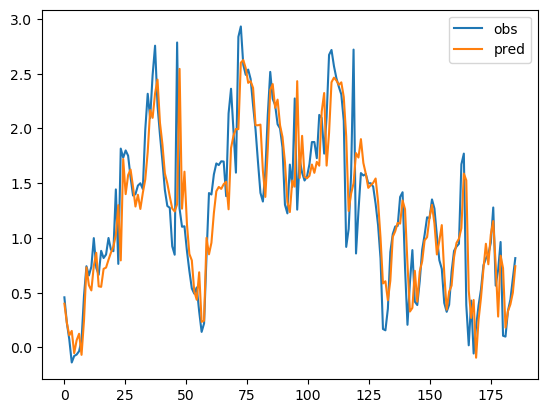

SMAPE avg 22.280959775463366, RMSE avg 0.20231110897100218


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


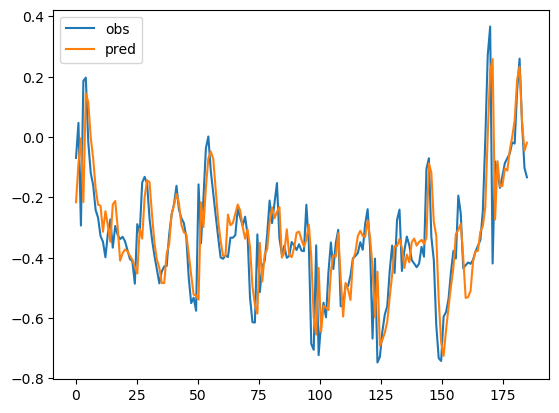

SMAPE avg 20.403978536485678, RMSE avg 0.1640493120137562


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


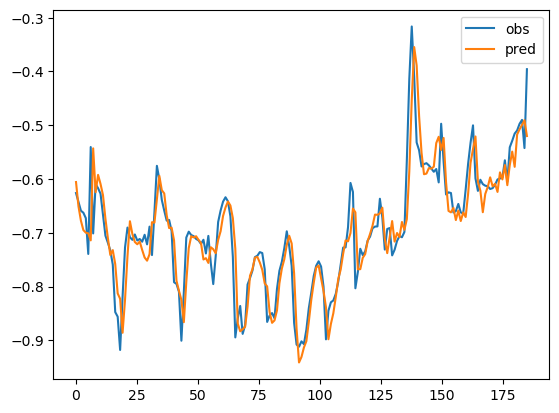

SMAPE avg 41.89884344285056, RMSE avg 0.6989179550779556


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


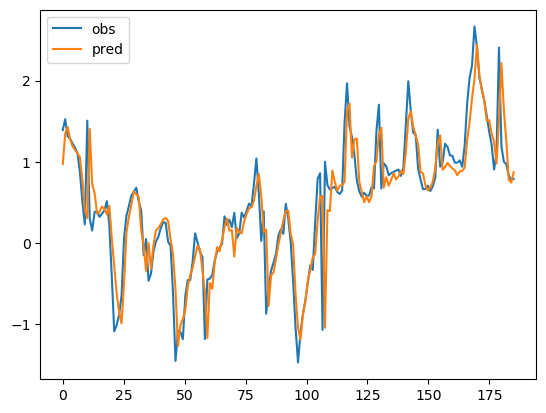

SMAPE avg 15.90210654867577, RMSE avg 0.1366495687662446


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


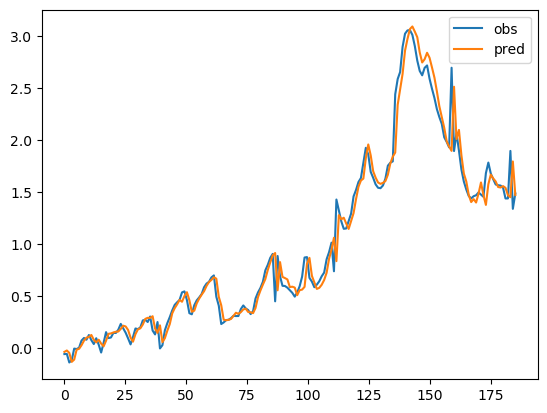

SMAPE avg 19.73296521361511, RMSE avg 0.17593717743305576


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


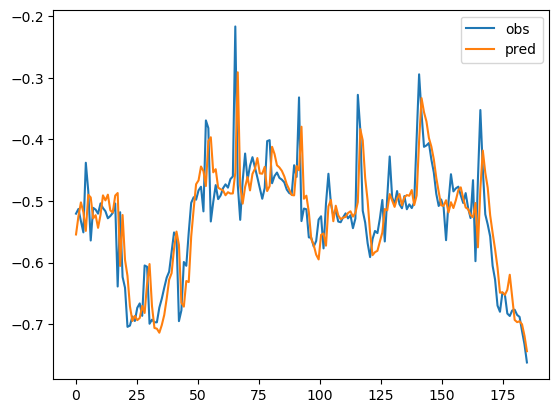

In [21]:
# The plots for SINGLE STEP PREDICTION

residual_data = full_data[3]
lag = 15
step = 1

for block_data in residual_data:
    X_train = block_data[0]
    y_train = block_data[1]
    X_valid = block_data[2]
    y_valid = block_data[3]
    
    SMAPE_sum = 0
    RMSE_sum = 0
        
    df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
    df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
    
    acc_forecast = np.array([])
    
    forecasting_model = VAR(df_train)
    results = forecasting_model.fit(lag)
    
    df_valid = pd.concat([df_train.loc[-lag: , :], df_valid])
    
    for i in range(0, len(df_valid)-lag):
        lagged_values = df_valid.values[i: i+lag]
        forecast = results.forecast(y = lagged_values, steps = step)[0][0]
        acc_forecast = np.append(acc_forecast, forecast)
        
        forecast = pd.DataFrame(np.array([forecast]), columns = ["pred"])
        
        SMAPE_sum += SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])
        RMSE_sum += RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])
    
    acc_forecast = pd.DataFrame({"pred": acc_forecast})
    print(f"SMAPE avg {SMAPE_sum / (len(df_valid) - lag)}, RMSE avg {RMSE_sum / (len(df_valid) - lag)}")
    draw_plot(df_valid.iloc[lag:200, 0], acc_forecast.iloc[:200-lag,0])

SMAPE avg 32.64218375582708, RMSE avg 0.3762708527180455


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


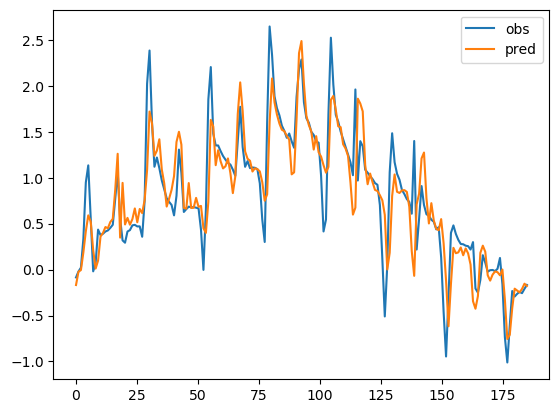

SMAPE avg 31.678663339715712, RMSE avg 0.35901932240677054


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


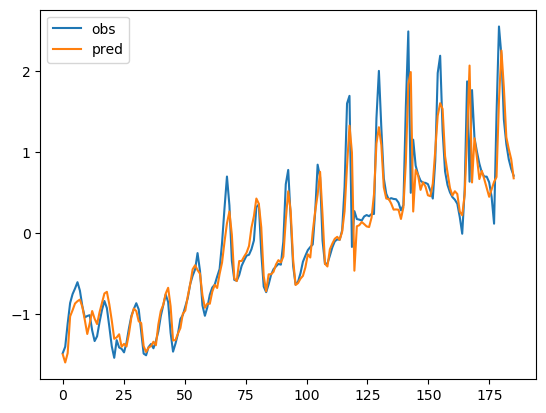

SMAPE avg 34.05265612098699, RMSE avg 0.391276602300893


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


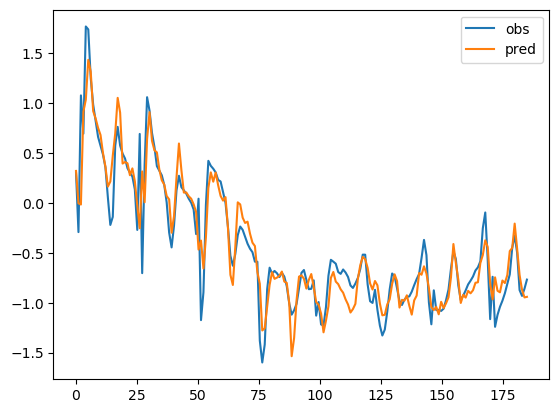

SMAPE avg 32.7699591717577, RMSE avg 0.38418107994674755


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


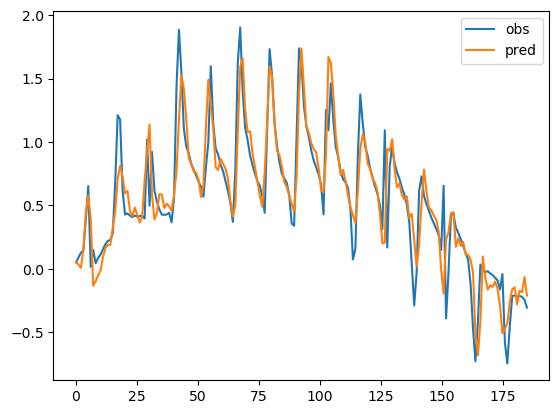

SMAPE avg 34.00478787682909, RMSE avg 0.38703135497873453


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


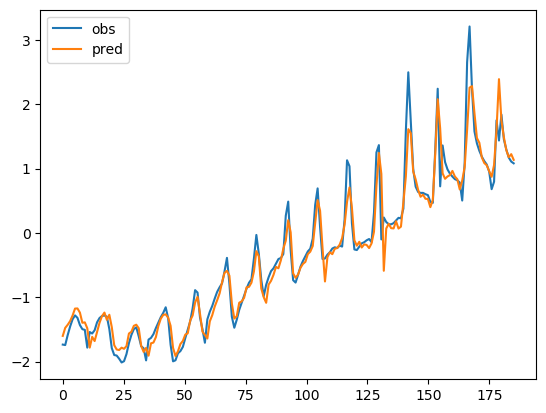

SMAPE avg 33.464139997907026, RMSE avg 0.3972607016239799


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


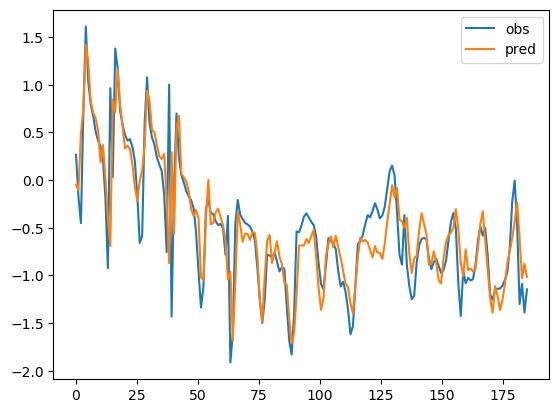

SMAPE avg 44.48181658741753, RMSE avg 0.5383810143189521


/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ac5852/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


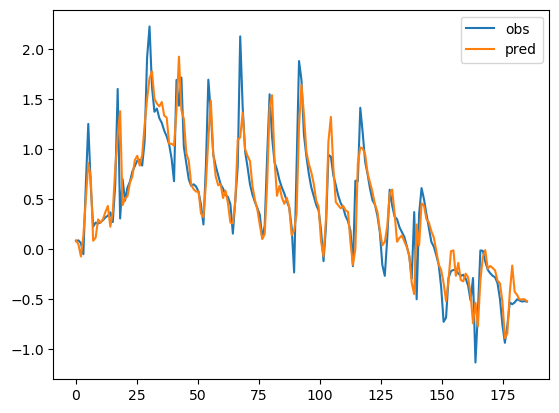

In [24]:
# The plots for SINGLE STEP PREDICTION
# seasonal 8760

residual_data = full_data[2]
lag = 15
step = 1

for block_data in residual_data:
    X_train = block_data[0]
    y_train = block_data[1]
    X_valid = block_data[2]
    y_valid = block_data[3]
    
    SMAPE_sum = 0
    RMSE_sum = 0
        
    df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
    df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
    
    acc_forecast = np.array([])
    
    forecasting_model = VAR(df_train)
    results = forecasting_model.fit(lag)
    
    df_valid = pd.concat([df_train.loc[-lag: , :], df_valid])
    
    for i in range(0, len(df_valid)-lag):
        lagged_values = df_valid.values[i: i+lag]
        forecast = results.forecast(y = lagged_values, steps = step)[0][0]
        acc_forecast = np.append(acc_forecast, forecast)
        
        forecast = pd.DataFrame(np.array([forecast]), columns = ["pred"])
        
        SMAPE_sum += SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])
        RMSE_sum += RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])
    
    acc_forecast = pd.DataFrame({"pred": acc_forecast})
    print(f"SMAPE avg {SMAPE_sum / (len(df_valid) - lag)}, RMSE avg {RMSE_sum / (len(df_valid) - lag)}")
    draw_plot(df_valid.iloc[lag:200, 0], acc_forecast.iloc[:200-lag,0])

In [36]:
# residual
# step size = 3
# lag = 15

given_data = full_data[4]
lag = 15
step = 3
size = 30

for block_data in given_data:
    X_train = block_data[0]
    y_train = block_data[1]
    X_valid = block_data[2]
    y_valid = block_data[3]
    SMAPE_sum = 0
    RMSE_sum = 0
    df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
    df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
    
    forecasting_model = VAR(df_train)
    results = forecasting_model.fit(lag)
    
    df_valid = pd.concat([df_train.loc[-lag: , :], df_valid])
    
    for i in range(0, len(df_valid)-lag):
        lagged_values = df_valid.values[i: i+lag]
        forecast = pd.DataFrame(results.forecast(y = lagged_values, steps = step), columns=df_train.columns)
        # print(forecast)
        SMAPE_sum += SMAPE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        RMSE_sum += RMSE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        #print(f"SMAPE {SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")
        #print(f"RMSE {RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")  
    print(f"SMAPE avg {SMAPE_sum / (len(df_valid) - lag)}, RMSE avg {RMSE_sum / (len(df_valid) - lag)}")
        #draw_plot(df_valid.iloc[i+1: i+step+1, [0]], forecast.iloc[:step,[0]])

SMAPE avg 30.739005456101083, RMSE avg 0.3821933612464577
SMAPE avg 33.68815419994691, RMSE avg 0.4151036045377636
SMAPE avg 33.924263733311754, RMSE avg 0.32381944797167633
SMAPE avg 25.37882324583908, RMSE avg 0.18067254384384382
SMAPE avg 29.61396057583867, RMSE avg 0.37435595764605084
SMAPE avg 26.291480231966492, RMSE avg 0.16340448085727752
SMAPE avg 43.1596563018297, RMSE avg 0.3107105147953482


In [37]:
# residual
# step size = 3
# lag = 24

given_data = full_data[4]
lag = 24
step = 3
size = 30

for block_data in given_data:
    X_train = block_data[0]
    y_train = block_data[1]
    X_valid = block_data[2]
    y_valid = block_data[3]
    SMAPE_sum = 0
    RMSE_sum = 0
    df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
    df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
    
    forecasting_model = VAR(df_train)
    results = forecasting_model.fit(lag)
    
    df_valid = pd.concat([df_train.loc[-lag: , :], df_valid])
    
    for i in range(0, len(df_valid)-lag):
        lagged_values = df_valid.values[i: i+lag]
        forecast = pd.DataFrame(results.forecast(y = lagged_values, steps = step), columns=df_train.columns)
        # print(forecast)
        SMAPE_sum += SMAPE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        RMSE_sum += RMSE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        #print(f"SMAPE {SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")
        #print(f"RMSE {RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")  
    print(f"SMAPE avg {SMAPE_sum / (len(df_valid) - lag)}, RMSE avg {RMSE_sum / (len(df_valid) - lag)}")
        #draw_plot(df_valid.iloc[i+1: i+step+1, [0]], forecast.iloc[:step,[0]])

SMAPE avg 36.473592263797705, RMSE avg 0.5071233955115882
SMAPE avg 40.20970730366964, RMSE avg 0.5432332181017638
SMAPE avg 40.63103294870147, RMSE avg 0.4385872607951684
SMAPE avg 30.771265703594104, RMSE avg 0.24620225687902672
SMAPE avg 35.221333544571955, RMSE avg 0.49371370462635966
SMAPE avg 31.389318302087865, RMSE avg 0.21941493462769487
SMAPE avg 48.75497727461902, RMSE avg 0.40516546318696645


In [25]:
# se8760
# step size = 3

given_data = full_data[3]
lag = 15
step = 3
size = 30

for block_data in given_data:
    X_train = block_data[0]
    y_train = block_data[1]
    X_valid = block_data[2]
    y_valid = block_data[3]
    SMAPE_sum = 0
    RMSE_sum = 0
       df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
    df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
    
    forecasting_model = VAR(df_train)
    results = forecasting_model.fit(lag)
    
    df_valid = pd.concat([df_train.loc[-lag: , :], df_valid])
    
    for i in range(0, len(df_valid)-lag):
        lagged_values = df_valid.values[i: i+lag]
        forecast = pd.DataFrame(results.forecast(y = lagged_values, steps = step), columns=df_train.columns)
        # print(forecast)
        SMAPE_sum += SMAPE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        RMSE_sum += RMSE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        #print(f"SMAPE {SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")
        #print(f"RMSE {RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")  
    print(f"SMAPE avg {SMAPE_sum / (len(df_valid) - lag)}, RMSE avg {RMSE_sum / (len(df_valid) - lag)}")
        #draw_plot(df_valid.iloc[i+1: i+step+1, [0]], forecast.iloc[:step,[0]])

SMAPE avg 33.05037080576541, RMSE avg 0.42236856802593203
SMAPE avg 36.720905361715396, RMSE avg 0.42855868801973457
SMAPE avg 21.847918626911603, RMSE avg 0.20768442167733087
SMAPE avg 20.252033752321648, RMSE avg 0.16857563305074527
SMAPE avg 40.21224350028253, RMSE avg 0.6882473770965528
SMAPE avg 15.891001664366891, RMSE avg 0.1419324268025524
SMAPE avg 19.905772462032417, RMSE avg 0.1838993894347616


In [29]:
# seasonanl 360
# step size = 3
# lag = 24

given_data = full_data[2]
lag = 24
step = 3
size = 30

for block_data in given_data:
    X_train = block_data[0]
    y_train = block_data[1]
    X_valid = block_data[2]
    y_valid = block_data[3]
    SMAPE_sum = 0
    RMSE_sum = 0
    df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
    df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
    
    forecasting_model = VAR(df_train)
    results = forecasting_model.fit(lag)
    
    df_valid = pd.concat([df_train.loc[-lag: , :], df_valid])
    
    for i in range(0, len(df_valid)-lag):
        lagged_values = df_valid.values[i: i+lag]
        forecast = pd.DataFrame(results.forecast(y = lagged_values, steps = step), columns=df_train.columns)
        # print(forecast)
        SMAPE_sum += SMAPE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        RMSE_sum += RMSE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        #print(f"SMAPE {SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")
        #print(f"RMSE {RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")  
    print(f"SMAPE avg {SMAPE_sum / (len(df_valid) - lag)}, RMSE avg {RMSE_sum / (len(df_valid) - lag)}")
        #draw_plot(df_valid.iloc[i+1: i+step+1, [0]], forecast.iloc[:step,[0]])

SMAPE avg 38.8002524375339, RMSE avg 0.5246712629290056
SMAPE avg 36.033892312430396, RMSE avg 0.47718944036620237
SMAPE avg 37.67400893538104, RMSE avg 0.5234979521052427
SMAPE avg 39.006771807063515, RMSE avg 0.5375358248983406
SMAPE avg 38.13833181890997, RMSE avg 0.5074506215663623
SMAPE avg 36.10554459891829, RMSE avg 0.509185542998816
SMAPE avg 46.56854537789702, RMSE avg 0.6646271911311759


In [30]:
# seasonanl 360
# step size = 3
# lag = 15

given_data = full_data[2]
lag = 15
step = 3
size = 30

for block_data in given_data:
    X_train = block_data[0]
    y_train = block_data[1]
    X_valid = block_data[2]
    y_valid = block_data[3]
    SMAPE_sum = 0
    RMSE_sum = 0
    df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
    df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
    
    forecasting_model = VAR(df_train)
    results = forecasting_model.fit(lag)
    
    df_valid = pd.concat([df_train.loc[-lag: , :], df_valid])
    
    for i in range(0, len(df_valid)-lag):
        lagged_values = df_valid.values[i: i+lag]
        forecast = pd.DataFrame(results.forecast(y = lagged_values, steps = step), columns=df_train.columns)
        # print(forecast)
        SMAPE_sum += SMAPE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        RMSE_sum += RMSE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        #print(f"SMAPE {SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")
        #print(f"RMSE {RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")  
    print(f"SMAPE avg {SMAPE_sum / (len(df_valid) - lag)}, RMSE avg {RMSE_sum / (len(df_valid) - lag)}")
        #draw_plot(df_valid.iloc[i+1: i+step+1, [0]], forecast.iloc[:step,[0]])

SMAPE avg 31.973464827303598, RMSE avg 0.3951896703221612
SMAPE avg 30.727084989647377, RMSE avg 0.37324242991770523
SMAPE avg 33.3349330445689, RMSE avg 0.41826759385990997
SMAPE avg 32.1063719172023, RMSE avg 0.4034336593779523
SMAPE avg 32.77868429012494, RMSE avg 0.40144669045776044
SMAPE avg 32.1518335255925, RMSE avg 0.41683464423248184
SMAPE avg 43.98782881255975, RMSE avg 0.5633156237509404


In [31]:
# seasonanl 24
# step size = 3
# lag = 15

given_data = full_data[1]
lag = 15
step = 3
size = 30

for block_data in given_data:
    X_train = block_data[0]
    y_train = block_data[1]
    X_valid = block_data[2]
    y_valid = block_data[3]
    SMAPE_sum = 0
    RMSE_sum = 0
    df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
    df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
    
    forecasting_model = VAR(df_train)
    results = forecasting_model.fit(lag)
    
    df_valid = pd.concat([df_train.loc[-lag: , :], df_valid])
    
    for i in range(0, len(df_valid)-lag):
        lagged_values = df_valid.values[i: i+lag]
        forecast = pd.DataFrame(results.forecast(y = lagged_values, steps = step), columns=df_train.columns)
        # print(forecast)
        SMAPE_sum += SMAPE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        RMSE_sum += RMSE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        #print(f"SMAPE {SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")
        #print(f"RMSE {RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")  
    print(f"SMAPE avg {SMAPE_sum / (len(df_valid) - lag)}, RMSE avg {RMSE_sum / (len(df_valid) - lag)}")
        #draw_plot(df_valid.iloc[i+1: i+step+1, [0]], forecast.iloc[:step,[0]])

SMAPE avg 68.30857858976749, RMSE avg 1.066597071095584
SMAPE avg 70.63402775283035, RMSE avg 1.0197521940439118
SMAPE avg 70.8186151090437, RMSE avg 1.0820435472338255
SMAPE avg 67.24748052757239, RMSE avg 1.035116436809168
SMAPE avg 70.80838254564645, RMSE avg 1.0493286702525204
SMAPE avg 71.70592345776224, RMSE avg 0.9884014568937879
SMAPE avg 70.57453489212591, RMSE avg 1.1088159049121207


In [32]:
# seasonanl 24
# step size = 3
# lag = 24

given_data = full_data[1]
lag = 24
step = 3
size = 30

for block_data in given_data:
    X_train = block_data[0]
    y_train = block_data[1]
    X_valid = block_data[2]
    y_valid = block_data[3]
    SMAPE_sum = 0
    RMSE_sum = 0
    df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
    df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
    
    forecasting_model = VAR(df_train)
    results = forecasting_model.fit(lag)
    
    df_valid = pd.concat([df_train.loc[-lag: , :], df_valid])
    
    for i in range(0, len(df_valid)-lag):
        lagged_values = df_valid.values[i: i+lag]
        forecast = pd.DataFrame(results.forecast(y = lagged_values, steps = step), columns=df_train.columns)
        # print(forecast)
        SMAPE_sum += SMAPE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        RMSE_sum += RMSE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        #print(f"SMAPE {SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")
        #print(f"RMSE {RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")  
    print(f"SMAPE avg {SMAPE_sum / (len(df_valid) - lag)}, RMSE avg {RMSE_sum / (len(df_valid) - lag)}")
        #draw_plot(df_valid.iloc[i+1: i+step+1, [0]], forecast.iloc[:step,[0]])

SMAPE avg 44.8641743271734, RMSE avg 0.6250429110572873
SMAPE avg 41.805946292020586, RMSE avg 0.5263516813666296
SMAPE avg 43.94586804382987, RMSE avg 0.5812159031543758
SMAPE avg 43.90166176474474, RMSE avg 0.6004714013439232
SMAPE avg 42.12955223759003, RMSE avg 0.5495035043534232
SMAPE avg 41.44790077852084, RMSE avg 0.5260429338597589
SMAPE avg 43.62138200608108, RMSE avg 0.5990340915589467


In [35]:
# trend
# step size = 3
# lag = 15

given_data = full_data[0]
lag = 15
step = 3
size = 30

for block_data in given_data:
    X_train = block_data[0]
    y_train = block_data[1]
    X_valid = block_data[2]
    y_valid = block_data[3]
    SMAPE_sum = 0
    RMSE_sum = 0
    df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
    df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')
    
    forecasting_model = VAR(df_train)
    results = forecasting_model.fit(lag)
    
    df_valid = pd.concat([df_train.loc[-lag: , :], df_valid])
    
    for i in range(0, len(df_valid)-lag):
        lagged_values = df_valid.values[i: i+lag]
        forecast = pd.DataFrame(results.forecast(y = lagged_values, steps = step), columns=df_train.columns)
        # print(forecast)
        SMAPE_sum += SMAPE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        RMSE_sum += RMSE(forecast.iloc[:step, [0]], df_valid.iloc[i+1: i+step+1, [0]])
        #print(f"SMAPE {SMAPE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")
        #print(f"RMSE {RMSE(forecast.iloc[:step,[0]], df_valid.iloc[i+1: i+step+1, [0]])}")  
    print(f"SMAPE avg {SMAPE_sum / (len(df_valid) - lag)}, RMSE avg {RMSE_sum / (len(df_valid) - lag)}")
        #draw_plot(df_valid.iloc[i+1: i+step+1, [0]], forecast.iloc[:step,[0]])

SMAPE avg 1.5658549421310903, RMSE avg 0.00957824074001329
SMAPE avg 1.4777392656459314, RMSE avg 0.007272094975184322
SMAPE avg 1.6647081894860332, RMSE avg 0.018267851309002707
SMAPE avg 1.432781905828162, RMSE avg 0.008271012637585113
SMAPE avg 1.4532604235888555, RMSE avg 0.006749502855107918
SMAPE avg 2.530283539699758, RMSE avg 0.016483606490104573
SMAPE avg 1.587216540711529, RMSE avg 0.009611531852863666


In [334]:
forecast

,0,pca1,pca2,pca3,pca4
0,0.402207,3.135330,1.704168,1.253320,1.287757
1,0.394622,3.041804,1.685845,1.256977,1.256756
2,0.384635,2.962302,1.634936,1.251046,1.177322
3,0.375292,2.888949,1.588743,1.249334,1.120168
4,0.366726,2.821551,1.532857,1.245904,1.060779
...,...,...,...,...,...
1247,-0.012901,0.038254,0.026795,0.024983,0.009897
1248,-0.012901,0.038254,0.026795,0.024983,0.009897
1249,-0.012901,0.038254,0.026795,0.024983,0.009897
1250,-0.012901,0.038254,0.026795,0.024983,0.009897


In [321]:
print(X_valid.isnull().sum())
print(forecast.iloc[:, [0]])

pca1    0
pca2    0
dtype: int64
             0
0     3.010469
1     3.013107
2     3.015745
3     3.018384
4     3.021023
...        ...
1247  6.231049
1248  6.233323
1249  6.235597
1250  6.237871
1251  6.240143

[1252 rows x 1 columns]


1252

In [296]:
for n in range(3):
    temp_aic = pd.merge(pd.Series([i for i in range(1, 40)]), results_aic[n], left_index=True, right_index=True, how='inner')                 
    temp_aic.plot(
        kind = "line",
        lw = 1,
        grid = True
    )

ValueError: Cannot merge a Series without a name

In [ ]:


for data in full_data:
    # trend -> seasonal -> residual
    estimate_ys = []
    estimate_y = []
    for block_data in data:
        # blocking cv
        X_train = block_data[0]
        y_train = block_data[1]
        X_valid = block_data[2]
        y_valid = block_data[3]
        
        df_train = pd.merge(y_train, X_train, left_index=True, right_index=True, how='inner')
        df_valid = pd.merge(y_valid, X_valid, left_index=True, right_index=True, how='inner')

        for p in range(1, 40):
            forecasting_model = VAR(df_train)
            results = forecasting_model.fit(p)
            aic[p-1] += results.aic

    yhat = model_fit.forecast(model_fit.y, steps=1)

## 3.3. LSTM

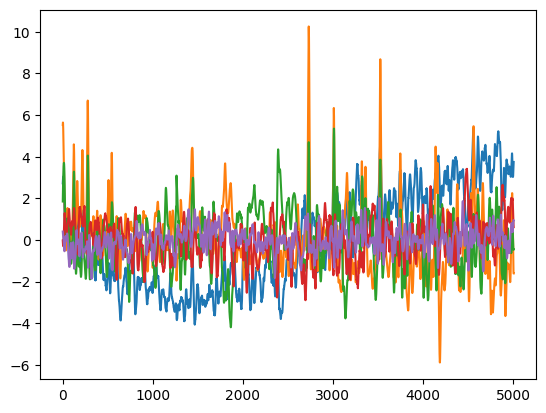

In [114]:
plt.plot(full_data[3][4][0])
plt.show()